# Clem's Machine Learning Template
## Post Operative Data

This is what Clem uses to scout out an initial data set for classification to get a "lay of the land".

While, it is unwise to favor a particular ML methodology, H2O's GBM has a lot of advantages that makes it really good for a first pass:

* Fast
* Robust to overfitting over a wide range of hyper parameters
* Handles both categorical and continous variables
* No need to scale the data

Change sections that are labeled:

    #@@@@@ CHANGE TO FIX SPECIFIC PROBLEM
    
This data is from:
https://archive.ics.uci.edu/ml/datasets/Post-Operative+Patient


## Data Preparation

In [60]:
# Python Libraries
from __future__ import division   # So that / does floating point division
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import commands
import math
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.mosaicplot import mosaic
import pylab

import h2o

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [5]:
#@@@@@ CHANGE TO FIX SPECIFIC PROBLEM

# Column names in case they aren't in an header

column_names =[
    "L-CORE",  # (patient's internal temperature in C):
               #  high (> 37), mid (>= 36 and <= 37), low (< 36)
     "L-SURF", # (patient's surface temperature in C):
               # high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)
     "L-O2",   # (oxygen saturation in %):
              # excellent (>= 98), good (>= 90 and < 98),
               # fair (>= 80 and < 90), poor (< 80)
     "L-BP",  #(last measurement of blood pressure):
              # high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)
     "SURF-STBL", # (stability of patient's surface temperature):
              # stable, mod-stable, unstable
     "CORE-STBL", # (stability of patient's core temperature)
               #table, mod-stable, unstable
     "BP-STBL",  #(stability of patient's blood pressure)
                 #stable, mod-stable, unstable
     "COMFORT",  #(patient's perceived comfort at discharge, measured as
                #an integer between 0 and 20)
     "decision" # ADM-DECS (discharge decision):
              #I (patient sent to Intensive Care Unit),
              #S (patient prepared to go home),
              #A (patient sent to general hospital floor)

]

In [44]:
#@@@@@ CHANGE TO FIX SPECIFIC PROBLEM

# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

# Very Problem specific

df = pd.read_csv(
    "post-operative.data",
    sep=",",
    # header=0,   # Row the header is on or None if no header present
    names=column_names,
    skipinitialspace = True,  # Skip spaces after delimiter
    na_values=['?'],
    comment=" ",   # Remove trailing space
)



In [13]:
# Names of columns - check to see if we got it right
df.columns.values

array(['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL',
       'BP-STBL', 'COMFORT', 'decision'], dtype=object)

In [8]:
df.head()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,decision
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


In [38]:
#@@@@@ CHANGE TO FIX SPECIFIC PROBLEM
# Drop any columns that don't make sense, if any
if False:
    df = df.drop("COLUMN-NAME-THAT-IS-USELESS",  #
                 1)  # 1 means drops in column direction
    
# Fix up any data

## Get Names of Columns

### Problem Specific
These are the values that are problem specific.  We use variable names from now on so that the code can be reused.

In [39]:
#@@@@@ CHANGE TO FIX SPECIFIC PROBLEM
YName = 'decision'     # Name of Response Variable
XUnknowCategoricalValue = None  # or string that represents no categorical





In [40]:
# Automatically convert response variable that are ints
# into catgorical values
if df[YName].dtype == 'int64':
    df[YName] = df[YName].astype("category", ordered=False)


Programmatically get list of names of:
* numeric features
* non-numeric features


In [45]:
# Names of all the input features 
XNames = [x for x in df.columns.values if x != YName]

# Names of all the Non-Numeric input features
XNonNumerics = [x for x in XNames \
                if not (df[x].dtype == np.float64 \
                        or df[x].dtype == np.int64)]

# Names of all the Non-Numeric input features
XNumerics = [x for x in XNames if x not in XNonNumerics]

# All the different Classification values that Y can take on
YValues = list(df[YName].unique())

print("-- Non-Numeric Input Feature Names:")
print(XNonNumerics)   # Of type pandas.core.series.Series
print("\n-- Numeric Input Feature Names:")
print(XNumerics)
print("\n-- All Input Feature Names:")
print(XNames)
print("\n-- Output (Response) Variable name:")
print(YName)
print("\n-- All possible values of Output (Response Variable):")
print(YValues)   # Classification values

-- Non-Numeric Input Feature Names:
['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL']

-- Numeric Input Feature Names:
['COMFORT']

-- All Input Feature Names:
['L-CORE', 'L-SURF', 'L-O2', 'L-BP', 'SURF-STBL', 'CORE-STBL', 'BP-STBL', 'COMFORT']

-- Output (Response) Variable name:
decision

-- All possible values of Output (Response Variable):
['A', 'S', 'I']


## Data Exploration

Here, we plot the data to get a sense of which data

In [46]:
df[XNumerics].dtypes 

COMFORT    float64
dtype: object

In [47]:
# how balanced is the data
for w in YValues:
    s = sum(list(df[YName] == w))
    print("{} is {:.1f}%".format(w,
                             100*s/len(df)))

A is 71.1%
S is 26.7%
I is 2.2%


### Numeric Data

In [48]:
df[XNumerics].describe()

,COMFORT
count,87.000000
mean,10.942529
std,2.304477
min,5.000000
25%,10.000000
50%,10.000000
75%,10.000000
max,15.000000


In [49]:
for xname in XNumerics:
    uniques = len(df[xname].unique())
    dtype = df[xname].dtypes
    if dtype == 'int64':
        range_x = df[xname].max() - df[xname].min() + 1
        print(
            "{} has {} int uniques with a density of {:.1f}% in range {}".format(
            xname, uniques, 100.0*uniques/range_x, range_x))
    else:
        range_x = df[xname].max() - df[xname].min()
        print("{} has {} float64 uniques in a range {:.1f}".format(
            xname, uniques, range_x))
       

COMFORT has 5 float64 uniques in a range 10.0


In [62]:
# Number of unknown Numeric Values
nrow = len(df)
for xname in XNumerics:
    count =  (df[xname].apply(math.isnan)).sum()
    if count > 0:
        print ("{} has {} '{}'s which is {:.1f}%".format(
            xname,
            count,
            XUnknowCategoricalValue,
            100.0*count/nrow))
        

COMFORT has 3 'None's which is 3.3%


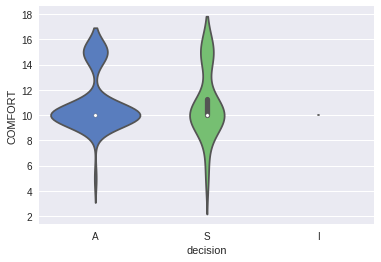

In [63]:
# Violin Plot of numeric data
for x in XNumerics:
    sns.violinplot(y = df[x],
                   x = df[YName],
                   # Width indicates relative count.  >50K is less frequent
                   scale="count" , 
                   inner="box",
                   palette="muted",
                   split=True
                  )
    plt.show()

### Non-Numeric Data

In [64]:
for xname in XNonNumerics:
    uniques = len(df[xname].unique())
    print("{} has {} uniques".format(
        xname, uniques))

L-CORE has 3 uniques
L-SURF has 3 uniques
L-O2 has 2 uniques
L-BP has 3 uniques
SURF-STBL has 2 uniques
CORE-STBL has 3 uniques
BP-STBL has 3 uniques


In [65]:
# Number of unknown NonNumeric Values
nrow = len(df)
for xname in XNonNumerics:
    count =  (df[xname] == XUnknowCategoricalValue).sum()
    if count > 0:
        print ("{} has {} '{}'s which is {:.1f}%".format(
            xname,
            count,
            XUnknowCategoricalValue,
            100.0*count/nrow))
        

In [66]:
df[XNonNumerics].describe()

,L-CORE,L-SURF,L-O2,L-BP,SURF-STBL,CORE-STBL,BP-STBL
count,90,90,90,90,90,90,90
unique,3,3,2,3,2,3,3
top,mid,mid,good,mid,stable,stable,stable
freq,58,48,47,57,45,83,46


### Number of unknown categorical values



In [67]:
nrow = len(df)
for xname in XNonNumerics:
    count =  (df[xname] == XUnknowCategoricalValue).sum()
    if count > 0:
        print ("{} has {} Unknowns which is {:.1f}%".format(
            xname, count, 100.0*count/nrow))
        

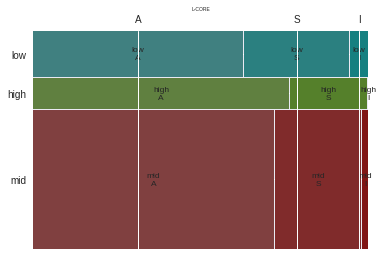

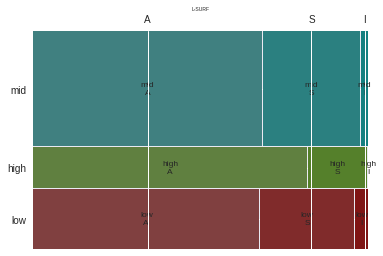

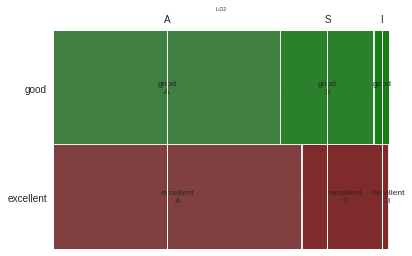

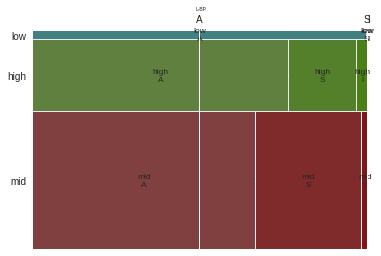

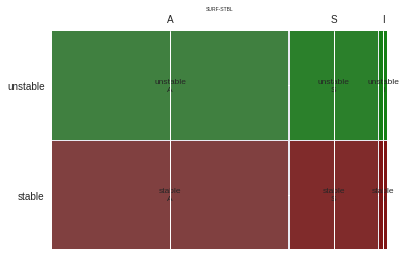

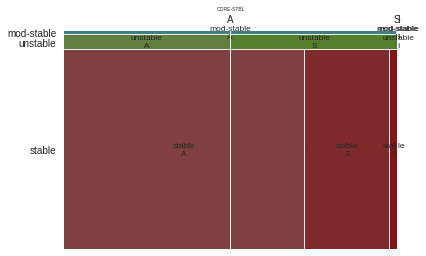

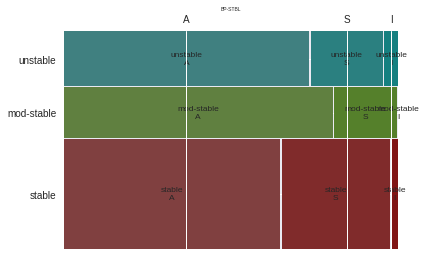

In [68]:
plt.rcParams['font.size'] = 10.0
# http://www.statsmodels.org/0.6.1/generated/statsmodels.graphics.mosaicplot.mosaic.html
    
for x in XNonNumerics:
    m = mosaic(df[[x, YName]],
           [x, YName],
           horizontal=False
          )
    pylab.xlabel(x, fontsize =5)
    pylab.show()

## Using H2O to get a first impression of variable importance

While the assignment prefers, a more "fundamental" approach, it has been my experience that running an initial H2O GBM (Gradient Boosted Machine) model has a number of advantages which are useful for gaining a first impression of the data.

H2O GBM

* has no need to scale the data
* can handle both categorical and continous features
* is robust against overfitting
* general builds a very good model
* is fast
* can show you variable importance in the model it builds.

However, the "No Free Lunch Theorem", does caution us from depending blindly on any one model.  https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization

George Box also says, "All models are wrong, but some are useful."

In [69]:
PName = "predict"   # The name of the predict field for H2O output
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,5 days 8 hours 31 mins
H2O cluster version:,3.10.4.7
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_clement_zanygn
H2O cluster total nodes:,1
H2O cluster free memory:,6.718 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [70]:
# Make the H2O version of the data frame
dfh = h2o.H2OFrame(df)
dfh[YName] = dfh[YName].asfactor()   # Force response

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [71]:
dfh[YName].anyfactor()

True

In [72]:
YValues

['A', 'S', 'I']

In [131]:
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

# For doing a grid search, see here:
# https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/gbm/gbmTuning.ipynb
    
    
gbm = h2o.estimators.gbm.H2OGradientBoostingEstimator(
   #  nfolds=4,
       # ntrees=10,
      #  max_depth=8,    # Of a tree
)
x = """
    # DEFAULTS:
    nfolds = 0,    # No cross validation folds
    ntrees=50,
    learn_rate=0.1,
    max_depth=5,    # Of a tree
    min_row=10,     # Fewest allowed observations in a leaf (weighted)
    nbins=20,   # For numeric cols, build histogram of at most this many bins
    stopping_tolerance=0.01, #10-fold increase in threshold as defined in rf_v1
    stopping_rounds=2,
    score_each_iteration=True,
"""

In [132]:
gbm.train(x=XNames, y=YName, training_frame=dfh)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [133]:
pred_train = gbm.predict(dfh)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [134]:
print ("Training error = {:.3f}".format(
    1 - (pred_train['predict'] == dfh[YName]).sum()/dfh.nrows))

print ("Training accuracy = {:.3f}".format(
    (pred_train['predict'] == dfh[YName]).sum()/dfh.nrows))


Training error = 0.233
Training accuracy = 0.767


In [135]:
pred_train

predict,A,I,S
A,0.759588,0.013835,0.226577
A,0.536838,0.0115711,0.45159
A,0.723825,0.0212762,0.254899
A,0.776312,0.0463463,0.177342
A,0.836759,0.00824283,0.154998
S,0.353943,0.0989238,0.547133
A,0.723968,0.0210818,0.25495
S,0.47173,0.00532738,0.522943
A,0.530554,0.0193591,0.450087
A,0.554989,0.0115489,0.433462


### F1 Score


$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

See:

https://en.wikipedia.org/wiki/F1_score

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html


In [136]:
# Multinominal classifier
f1 = f1_score(dfh[YName].as_data_frame()[YName].tolist(),
     pred_train[PName].as_data_frame()[PName].tolist(),
     average=None,         
     labels=YValues
     )    
for i, yvalue in enumerate(YValues):
    print("F1 Score for y = '{}' is {:.3f}".format(yvalue, f1[i]))


F1 Score for y = 'A' is 0.863
F1 Score for y = 'S' is 0.375
F1 Score for y = 'I' is 0.000


### ROC

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html


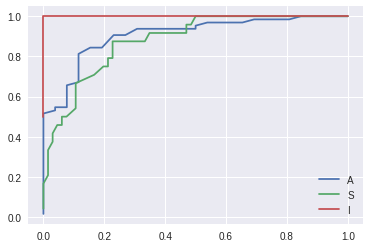

-- AUC is 1.000


In [137]:
for i, yvalue in enumerate(YValues):
    # Get the True and Predicted values
    y_true = list(df[YName])
    y_true = map(lambda x : 1 if x == yvalue else 0, y_true)

    # These are the predicted probabilities
    if type(yvalue) is str:
        yvalue_column_name = yvalue
        y_pred = pred_train[yvalue].as_data_frame()[yvalue].tolist()
    else:
        yvalue_column_name = "p" + str(yvalue)
        y_pred = (pred_train.as_data_frame()[yvalue_column_name].tolist())

    # Area Under the ROC Curve (AUC)
    auc = roc_auc_score(y_true, y_pred)
    FalsePositiveRate, TruePositiveRate, thresholds = roc_curve(
        y_true,
        y_pred)
    pylab.plot(FalsePositiveRate,
                           TruePositiveRate,
                           label=yvalue)
pylab.legend(loc='lower right', shadow=True)
pylab.show()

print("-- AUC is {:.3f}".format(auc))


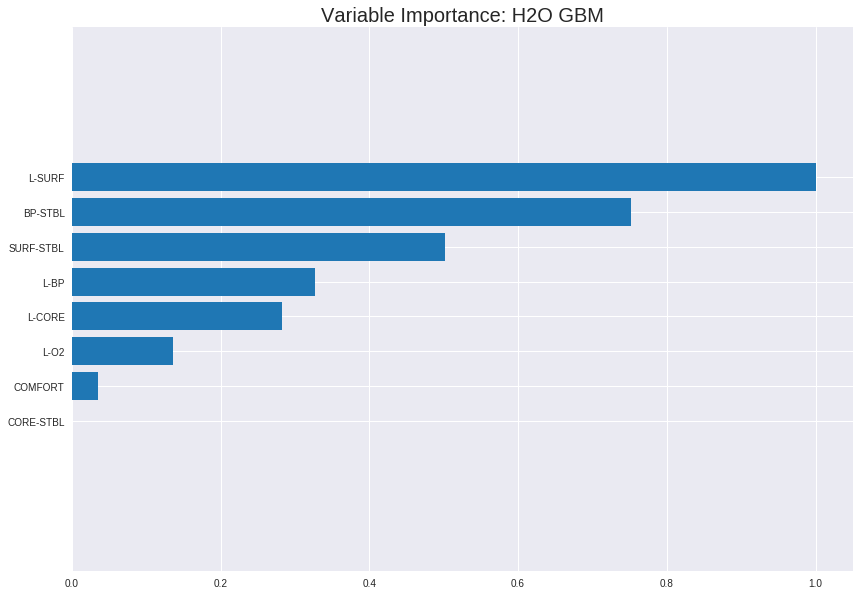

In [138]:
gbm.varimp_plot()

In [139]:
varimp = pd.DataFrame(gbm.varimp(),
             columns=
             ["variable",
              "relative_importance",
              "scaled_importance",
              "percentage"]
            )
top5 = varimp['variable'][0:5].tolist() + [YName]
varimp

,variable,relative_importance,scaled_importance,percentage
0,L-SURF,16.595419,1.000000,0.329607
1,BP-STBL,12.475285,0.751731,0.247775
2,SURF-STBL,8.326869,0.501757,0.165382
3,L-BP,5.431911,0.327314,0.107885
4,L-CORE,4.688613,0.282525,0.093122
5,L-O2,2.252546,0.135733,0.044738
6,COMFORT,0.578537,0.034861,0.011491
7,CORE-STBL,0.000000,0.000000,0.000000


In [34]:
# TBD - figure out a pairs plot for top 5 most important variables
#  -- tricky - how to do it with both categorical and numeric values

# from pandas.tools.plotting import scatter_matrix
# scatter_matrix(df[top5],

#### df[top5].plot(subplots=True, layout)

In [ ]:
if False:
    h2o.shutdown(prompt = False)